In [1]:
import torch
import data
import tqdm
import models
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Loading the configuration file, which contains information about the simulated images, and the telescopes they were modelled on, and some model hyperparameters

In [2]:
with open('config.json') as config_file:
    config = json.load(config_file)

In [3]:
EPOCHS = 150
LR = 1e-5
IN_SHAPE = config["image_shape_2"] # image dimensions in pixels (assuming square image)
MAGNIFICATION = config["magnification"] # magnitude of each magnification
N_MAG = config["n_magnification"] # number of magnifications required to be performed
DELTA = config["resolution_3"] # LR image resolution
alpha_t_scaling = config["alpha_t_scaling"] # scaling coefficient of the tangential component of the deflection angle 
VDL_WEIGHT = 0.5 # initial vdl weight

### Scaling the deflection angle obtained from the SISR models:
The deflection angle values are obtained by design as $\alpha(x,y) \in (0,1)$. They are thus rescaled within appropriate bounds before their use for the purpose of lensing. The coefficients 1 and 2 correspond to the radial $\alpha_r(x,y)$ and tangential $\alpha_t(x,y)$ components of the deflection angle. While $\alpha_r(x,y)$ can ideally be used to contain all the pertaining information, this is no longer required ot be true, as the image space is discretized to pixels. To account for potential inaccuracies brought by this discretization, a (smaller) $\alpha_t(x,y)$ is used for the purpose of potential correction.

In [ ]:
alpha_bounds = [config["alpha_l"],config["alpha_h"]] # bounds for the deflection angle, used in it's scaling

alpha_coeff_1 = torch.tensor(alpha_bounds[1]-alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff_2 = torch.tensor((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_coeff = torch.concat([alpha_coeff_1, alpha_coeff_2],dim=1)

alpha_disp_1 = torch.tensor(alpha_bounds[0]).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp_2 = torch.tensor(-((alpha_bounds[1]-alpha_bounds[0])*alpha_t_scaling)/2).repeat((IN_SHAPE*MAGNIFICATION*N_MAG)**2).view(1,1,IN_SHAPE*MAGNIFICATION*N_MAG,IN_SHAPE*MAGNIFICATION*N_MAG)
alpha_disp = torch.concat([alpha_disp_1, alpha_disp_2],dim=1)

def alpha_scaling(alpha):
    """
    Scales the deflection angle obtained from the model to meaningful bounds
    
    :param alpha: Deflection angle to be scaled
    :return: Scaled deflection angle
    """
    alpha = alpha * alpha_coeff.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    alpha = alpha + alpha_disp.repeat(alpha.shape[0],1,1,1).to(alpha.device)
    return alpha

### Loading the datasets, the dataloaders and performing the required train:validation partitions
A batch size of 5 (merely for computational convenience) is used 5000 images for training, which is divided by an 80:20 validation split. The 5000 images are derived more-or-less equally from the three DM sub-structure classes. There are no high-resolution images loaded as they are not needed !

In [4]:
# We can now load the datasets, combine and shuffle them to have a (close to) homogenous distribution of all sub-structures.
BATCH_SIZE = 5 # Feel free to increase this number; all the training was done on my personal machine, hence, this limitation/

dataset_no_sub = data.LensingDataset('../Simulations/data_model_3/',['no_sub'],5000)
train_dataset_no_sub, val_dataset_no_sub = torch.utils.data.random_split(dataset_no_sub, [0.8, 0.2])

dataset_axion = data.LensingDataset('../Simulations/data_model_3/',['axion'],5000)
train_dataset_axion, val_dataset_axion = torch.utils.data.random_split(dataset_axion, [0.8, 0.2])

dataset_cdm = data.LensingDataset('../Simulations/data_model_3/',['cdm'],5000)
train_dataset_cdm, val_dataset_cdm = torch.utils.data.random_split(dataset_cdm, [0.8, 0.2])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_no_sub, train_dataset_axion, train_dataset_cdm])
val_dataset = torch.utils.data.ConcatDataset([val_dataset_no_sub, val_dataset_axion, val_dataset_cdm])

train_dataset, train_rest = torch.utils.data.random_split(train_dataset, [0.34, 0.66])
val_dataset, val_rest = torch.utils.data.random_split(val_dataset, [0.34, 0.66])

train_dataloader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)
val_dataloader = torch.utils.data.DataLoader(val_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

# This configuration will load 5000 (low-resolution) images in total, with a 80:20 validation split. 

### Model and physics-inspired loss function loading

In [5]:
# We construct and load the SISR model to the GPU (if available). A loss module is also loaded that performs all the operations required during training.

alpha_model = models.SISR(magnification=MAGNIFICATION, n_mag=N_MAG, residual_depth=config["alpha_depth"], in_channels=1, latent_channel_count=config["latent_channels"]).to(device)
lens_loss = models.SersicProfiler(resolution=DELTA, device=device, sersic_args = [1, 1, 0.25], vdl_weight=VDL_WEIGHT)

opt = torch.optim.Adam(params=alpha_model.parameters(),lr=LR)
alpha_params = sum(p.numel() for p in alpha_model.parameters())
print(f"Image network parameters: {alpha_params}")

Image network parameters: 900422


### Performing weight initialization
Several studies have shown that model weight initialization can help in more effective convergence.

In [6]:
# Performing He initialization of the model weights.

def init_weights(m):
    """
    Iterates through all the convolution and fully connected layers of the model to initialize all their weights

    :param m: Model to be initialized
    """
    if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
        torch.nn.init.kaiming_normal_(m.weight)  # He initialization
        if m.bias is not None:
            torch.nn.init.constant_(m.bias, 0)

alpha_model.apply(init_weights)

SISR(
  (residual_layer_list): ModuleList(
    (0-2): 3 x Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (subpixel_layer_list): ModuleList(
    (0): Sequential(
      (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PixelShuffle(upscale_factor=2)
      (2): ReLU()
    )
  )
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv3): Conv2d(64, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2

### Defining functions that sample the model's performance

In [7]:
def give_random_image(dataset, alpha_model, length, i=None, plot=True):
    """
    Provides a random image for evaluation

    :param dataset: Dataset used
    :param alpha_model: Model used
    :param length: Length of dataset used
    :param i: Index of the selected image, default: 
    :param plot: If true, also plots the source fitting graphs
    :return: original LR image, SR image, reconstructed source
    """
    if i == None:
        i = np.random.randint(low=0,high=length)
    LR = dataset[i].view(1,1,IN_SHAPE,IN_SHAPE).float()
    alpha = alpha_scaling(alpha_model(LR.float().to(device)).detach())
    sersic_profile, LR, source_profile = lens_loss.get_sample(alpha.to(device), LR.to(device), plot)
    LR_im = Image.fromarray(LR.cpu().detach().numpy()[0]*255)
    sersic_im = Image.fromarray(sersic_profile.cpu().detach().numpy()[0]*255)
    source_im = Image.fromarray(source_profile.cpu().detach().numpy()[0]*255)
    return (LR_im, sersic_im, source_im)

def show_random_image(image_tuple):
    """
    Displays the images provided by the give_random_image function
    
    :param image_tuple: Tuple of images returned by the give_random_image function
    """
    LR_im, sersic_im, source_im = image_tuple[0], image_tuple[1], image_tuple[2]
    plot, axes = plt.subplots(1,3)
    plot.set_size_inches(18,6)
    axes[0].imshow(LR_im)
    axes[1].imshow(sersic_im)
    axes[2].imshow(source_im)
    axes[0].set_title("LR_interpolated")
    axes[1].set_title("Image")
    axes[2].set_title("Source Profile")

/home/ashankar/Documents/Work/.env/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


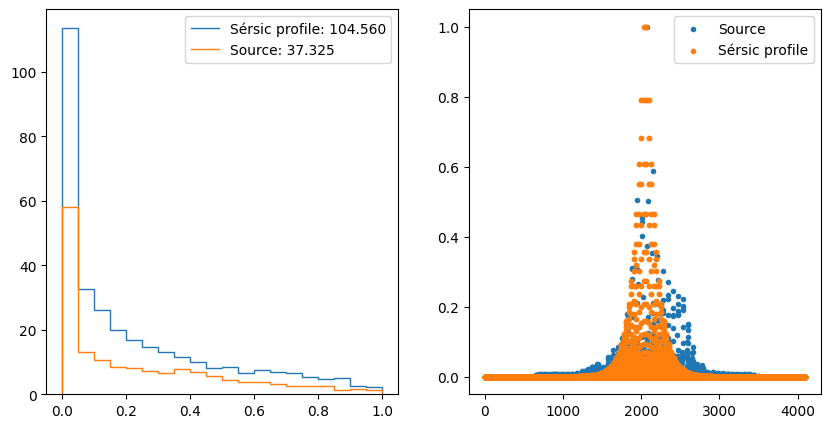

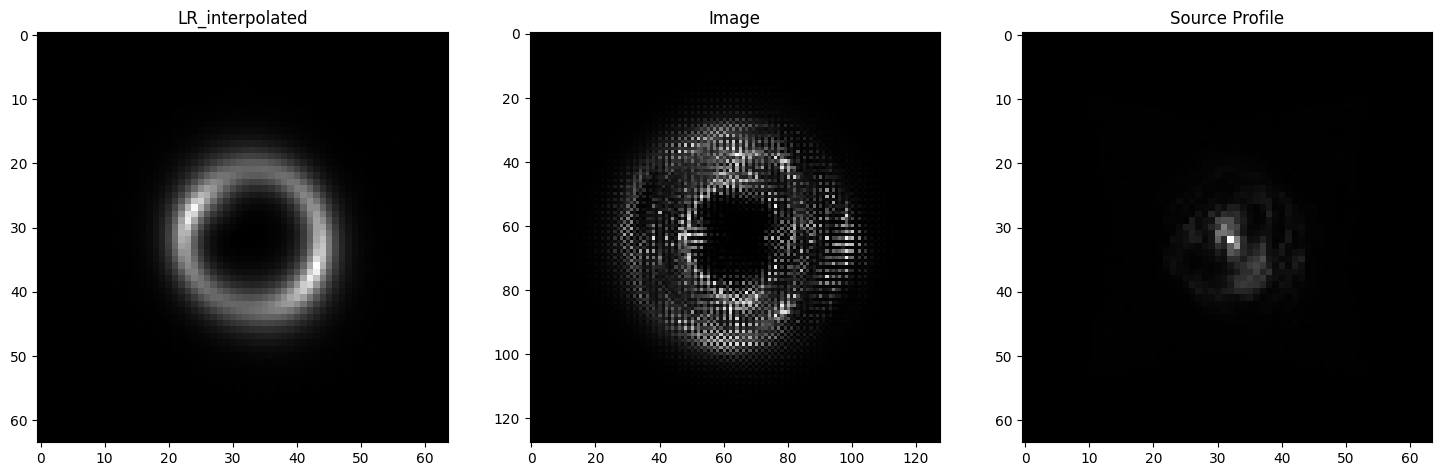

In [8]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

### The training sequence
The model is trained over the set number of epochs over the training images, and subsequently validated on the validation set. For both, the deflection angle given by the model is used to perform lensing, and is trained in an unsupervised manner by imposing the lensing system's constraints. Since the loss module is composed of various components, each of them is tracked for further study if required. In addition, the training process is stored as GIFs of the SR images, the LR images, and the reconstructed source.

In [9]:
# Training Sequence

best_val_loss = np.inf
best_weights = None
history = {'pre_loss':[],'val_loss':[], 'loss':[], 'images':[], 'lr':[], 'source':[]} # tracks the train and val losses and training results at each epoch
history_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]} # tracks the individual train loss components at each epoch
for epoch in range(EPOCHS):
    losses = []
    alpha_model.train()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    for i,(x) in enumerate(tqdm.tqdm(train_dataloader, desc=f"Training epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_model(x)
        alpha = alpha_scaling(alpha)
        loss, history_individual = lens_loss(alpha, x)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(float(loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    for key in individual_losses.keys():
        if individual_losses[key][-1] != None:
            history_losses[key].append(np.mean(individual_losses[key]))
        else:
            history_losses[key].append(None)
    if np.isnan(losses[-1]): 
        break
    print(f"Training at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    history['loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    alpha_model.eval()
    individual_losses = {'source_0':[], 'source_1':[], 'source_2':[], 'image_0':[], 'alpha_0':[]}
    losses = []
    for i,(x) in enumerate(tqdm.tqdm(val_dataloader, desc=f"Validation epoch {epoch+1}")):
        (x) = (x.float().to(device))
        alpha = alpha_scaling(alpha_model(x))
        val_loss, history_individual = lens_loss(alpha, x)
        losses.append(float(val_loss))
        for key in individual_losses.keys():
            if history_individual[key] != None:
                individual_losses[key].append(float(history_individual[key]))
            else:
                individual_losses[key].append(None)
    if best_val_loss > np.mean(losses) and np.mean(losses) != np.nan:
        best_val_loss = np.mean(losses)
        best_weights = alpha_model.state_dict()
    history['val_loss'].append(np.mean(losses) - float(np.mean(individual_losses['alpha_0'])))
    print(f"Validation at epoch {epoch+1}/{EPOCHS}: {np.mean(losses) - float(np.mean(individual_losses['alpha_0']))} at LR={opt.param_groups[0]['lr']}")
    lr, im, sr = give_random_image(val_dataset, alpha_model, len(val_dataset),50, plot=False)
    history['lr'].append(lr)
    history['images'].append(im)
    history['source'].append(sr)

Training epoch 1: 100%|██████████| 816/816 [00:33<00:00, 24.34it/s]


Training at epoch 1/150: 0.024464642190757918 at LR=1e-05


Validation epoch 1: 100%|██████████| 204/204 [00:03<00:00, 51.81it/s]


Validation at epoch 1/150: 0.02231412229365578 at LR=1e-05


Training epoch 2: 100%|██████████| 816/816 [00:34<00:00, 23.99it/s]


Training at epoch 2/150: 0.020764491676042482 at LR=1e-05


Validation epoch 2: 100%|██████████| 204/204 [00:03<00:00, 52.30it/s]


Validation at epoch 2/150: 0.017854308791677743 at LR=1e-05


Training epoch 3: 100%|██████████| 816/816 [00:33<00:00, 24.02it/s]


Training at epoch 3/150: 0.015915876434768973 at LR=1e-05


Validation epoch 3: 100%|██████████| 204/204 [00:03<00:00, 51.77it/s]


Validation at epoch 3/150: 0.01360306508072159 at LR=1e-05


Training epoch 4: 100%|██████████| 816/816 [00:34<00:00, 23.78it/s]


Training at epoch 4/150: 0.01259046427074674 at LR=1e-05


Validation epoch 4: 100%|██████████| 204/204 [00:04<00:00, 50.61it/s]


Validation at epoch 4/150: 0.011771389863033794 at LR=1e-05


Training epoch 5: 100%|██████████| 816/816 [00:35<00:00, 23.12it/s]


Training at epoch 5/150: 0.011631934310072194 at LR=1e-05


Validation epoch 5: 100%|██████████| 204/204 [00:04<00:00, 46.42it/s]


Validation at epoch 5/150: 0.011737899763473107 at LR=1e-05


Training epoch 6: 100%|██████████| 816/816 [00:35<00:00, 22.69it/s]


Training at epoch 6/150: 0.011851118352519823 at LR=1e-05


Validation epoch 6: 100%|██████████| 204/204 [00:04<00:00, 46.15it/s]


Validation at epoch 6/150: 0.011655504550492647 at LR=1e-05


Training epoch 7: 100%|██████████| 816/816 [00:36<00:00, 22.48it/s]


Training at epoch 7/150: 0.012254111683361378 at LR=1e-05


Validation epoch 7: 100%|██████████| 204/204 [00:04<00:00, 46.77it/s]


Validation at epoch 7/150: 0.012222731707380245 at LR=1e-05


Training epoch 8: 100%|██████████| 816/816 [00:36<00:00, 22.38it/s]


Training at epoch 8/150: 0.012723318356495606 at LR=1e-05


Validation epoch 8: 100%|██████████| 204/204 [00:04<00:00, 46.19it/s]


Validation at epoch 8/150: 0.014190988941574651 at LR=1e-05


Training epoch 9: 100%|██████████| 816/816 [00:36<00:00, 22.39it/s]


Training at epoch 9/150: 0.012560401637422142 at LR=1e-05


Validation epoch 9: 100%|██████████| 204/204 [00:04<00:00, 45.73it/s]


Validation at epoch 9/150: 0.012925340654784996 at LR=1e-05


Training epoch 10: 100%|██████████| 816/816 [00:36<00:00, 22.18it/s]


Training at epoch 10/150: 0.012688378853079699 at LR=1e-05


Validation epoch 10: 100%|██████████| 204/204 [00:04<00:00, 45.99it/s]


Validation at epoch 10/150: 0.01299057454875141 at LR=1e-05


Training epoch 11: 100%|██████████| 816/816 [00:36<00:00, 22.31it/s]


Training at epoch 11/150: 0.012966147250742376 at LR=1e-05


Validation epoch 11: 100%|██████████| 204/204 [00:04<00:00, 46.44it/s]


Validation at epoch 11/150: 0.013393595884325822 at LR=1e-05


Training epoch 12: 100%|██████████| 816/816 [00:36<00:00, 22.36it/s]


Training at epoch 12/150: 0.012956228670458692 at LR=1e-05


Validation epoch 12: 100%|██████████| 204/204 [00:04<00:00, 44.23it/s]


Validation at epoch 12/150: 0.01340201020231653 at LR=1e-05


Training epoch 13: 100%|██████████| 816/816 [00:36<00:00, 22.37it/s]


Training at epoch 13/150: 0.01272977943938481 at LR=1e-05


Validation epoch 13: 100%|██████████| 204/204 [00:04<00:00, 46.68it/s]


Validation at epoch 13/150: 0.012743623942072853 at LR=1e-05


Training epoch 14: 100%|██████████| 816/816 [00:36<00:00, 22.28it/s]


Training at epoch 14/150: 0.01262739319302936 at LR=1e-05


Validation epoch 14: 100%|██████████| 204/204 [00:04<00:00, 45.59it/s]


Validation at epoch 14/150: 0.013027796072670824 at LR=1e-05


Training epoch 15: 100%|██████████| 816/816 [00:36<00:00, 22.23it/s]


Training at epoch 15/150: 0.012713249893482392 at LR=1e-05


Validation epoch 15: 100%|██████████| 204/204 [00:04<00:00, 45.54it/s]


Validation at epoch 15/150: 0.01213298761742372 at LR=1e-05


Training epoch 16: 100%|██████████| 816/816 [00:36<00:00, 22.25it/s]


Training at epoch 16/150: 0.012274743046659483 at LR=1e-05


Validation epoch 16: 100%|██████████| 204/204 [00:04<00:00, 45.81it/s]


Validation at epoch 16/150: 0.01227456942547624 at LR=1e-05


Training epoch 17: 100%|██████████| 816/816 [00:36<00:00, 22.15it/s]


Training at epoch 17/150: 0.012064100632914252 at LR=1e-05


Validation epoch 17: 100%|██████████| 204/204 [00:04<00:00, 47.14it/s]


Validation at epoch 17/150: 0.012042073848515786 at LR=1e-05


Training epoch 18: 100%|██████████| 816/816 [00:36<00:00, 22.14it/s]


Training at epoch 18/150: 0.011854249823098895 at LR=1e-05


Validation epoch 18: 100%|██████████| 204/204 [00:04<00:00, 46.32it/s]


Validation at epoch 18/150: 0.01228703274368765 at LR=1e-05


Training epoch 19: 100%|██████████| 816/816 [00:36<00:00, 22.15it/s]


Training at epoch 19/150: 0.011700091578235266 at LR=1e-05


Validation epoch 19: 100%|██████████| 204/204 [00:04<00:00, 46.23it/s]


Validation at epoch 19/150: 0.011226589920446643 at LR=1e-05


Training epoch 20: 100%|██████████| 816/816 [00:37<00:00, 21.93it/s]


Training at epoch 20/150: 0.011250656053615624 at LR=1e-05


Validation epoch 20: 100%|██████████| 204/204 [00:04<00:00, 44.88it/s]


Validation at epoch 20/150: 0.011383891124483746 at LR=1e-05


Training epoch 21: 100%|██████████| 816/816 [00:36<00:00, 22.12it/s]


Training at epoch 21/150: 0.010817296450898307 at LR=1e-05


Validation epoch 21: 100%|██████████| 204/204 [00:04<00:00, 46.57it/s]


Validation at epoch 21/150: 0.01058504821997428 at LR=1e-05


Training epoch 22: 100%|██████████| 816/816 [00:36<00:00, 22.43it/s]


Training at epoch 22/150: 0.010418128557206478 at LR=1e-05


Validation epoch 22: 100%|██████████| 204/204 [00:04<00:00, 46.67it/s]


Validation at epoch 22/150: 0.010693198322733938 at LR=1e-05


Training epoch 23: 100%|██████████| 816/816 [00:36<00:00, 22.22it/s]


Training at epoch 23/150: 0.010472144811715493 at LR=1e-05


Validation epoch 23: 100%|██████████| 204/204 [00:04<00:00, 46.10it/s]


Validation at epoch 23/150: 0.009812333790571703 at LR=1e-05


Training epoch 24: 100%|██████████| 816/816 [00:36<00:00, 22.30it/s]


Training at epoch 24/150: 0.010192429727883826 at LR=1e-05


Validation epoch 24: 100%|██████████| 204/204 [00:04<00:00, 45.90it/s]


Validation at epoch 24/150: 0.010029087110203418 at LR=1e-05


Training epoch 25: 100%|██████████| 816/816 [00:36<00:00, 22.34it/s]


Training at epoch 25/150: 0.009983339851982345 at LR=1e-05


Validation epoch 25: 100%|██████████| 204/204 [00:04<00:00, 47.31it/s]


Validation at epoch 25/150: 0.009538211086513839 at LR=1e-05


Training epoch 26: 100%|██████████| 816/816 [00:36<00:00, 22.38it/s]


Training at epoch 26/150: 0.009977067527406867 at LR=1e-05


Validation epoch 26: 100%|██████████| 204/204 [00:04<00:00, 46.58it/s]


Validation at epoch 26/150: 0.010148516504605319 at LR=1e-05


Training epoch 27: 100%|██████████| 816/816 [00:36<00:00, 22.39it/s]


Training at epoch 27/150: 0.009560487036794133 at LR=1e-05


Validation epoch 27: 100%|██████████| 204/204 [00:04<00:00, 46.57it/s]


Validation at epoch 27/150: 0.009592276520219028 at LR=1e-05


Training epoch 28: 100%|██████████| 816/816 [00:36<00:00, 22.19it/s]


Training at epoch 28/150: 0.009369306687742709 at LR=1e-05


Validation epoch 28: 100%|██████████| 204/204 [00:04<00:00, 46.86it/s]


Validation at epoch 28/150: 0.009637861643853943 at LR=1e-05


Training epoch 29: 100%|██████████| 816/816 [00:36<00:00, 22.38it/s]


Training at epoch 29/150: 0.009320887258760267 at LR=1e-05


Validation epoch 29: 100%|██████████| 204/204 [00:04<00:00, 46.67it/s]


Validation at epoch 29/150: 0.009580384001453114 at LR=1e-05


Training epoch 30: 100%|██████████| 816/816 [00:36<00:00, 22.38it/s]


Training at epoch 30/150: 0.00924217794275975 at LR=1e-05


Validation epoch 30: 100%|██████████| 204/204 [00:04<00:00, 47.49it/s]


Validation at epoch 30/150: 0.008998623110100572 at LR=1e-05


Training epoch 31: 100%|██████████| 816/816 [00:36<00:00, 22.53it/s]


Training at epoch 31/150: 0.008920208590793396 at LR=1e-05


Validation epoch 31: 100%|██████████| 204/204 [00:04<00:00, 46.86it/s]


Validation at epoch 31/150: 0.00912609233038144 at LR=1e-05


Training epoch 32: 100%|██████████| 816/816 [00:36<00:00, 22.49it/s]


Training at epoch 32/150: 0.008920851085099903 at LR=1e-05


Validation epoch 32: 100%|██████████| 204/204 [00:04<00:00, 46.38it/s]


Validation at epoch 32/150: 0.009004092111889107 at LR=1e-05


Training epoch 33: 100%|██████████| 816/816 [00:36<00:00, 22.16it/s]


Training at epoch 33/150: 0.008623627716944754 at LR=1e-05


Validation epoch 33: 100%|██████████| 204/204 [00:04<00:00, 44.58it/s]


Validation at epoch 33/150: 0.008176479644972978 at LR=1e-05


Training epoch 34: 100%|██████████| 816/816 [00:37<00:00, 21.99it/s]


Training at epoch 34/150: 0.00838072677773501 at LR=1e-05


Validation epoch 34: 100%|██████████| 204/204 [00:04<00:00, 44.99it/s]


Validation at epoch 34/150: 0.008746054290860034 at LR=1e-05


Training epoch 35: 100%|██████████| 816/816 [00:36<00:00, 22.09it/s]


Training at epoch 35/150: 0.008250898746921973 at LR=1e-05


Validation epoch 35: 100%|██████████| 204/204 [00:04<00:00, 45.23it/s]


Validation at epoch 35/150: 0.008130160078757862 at LR=1e-05


Training epoch 36: 100%|██████████| 816/816 [00:37<00:00, 22.03it/s]


Training at epoch 36/150: 0.00804177619555084 at LR=1e-05


Validation epoch 36: 100%|██████████| 204/204 [00:04<00:00, 46.05it/s]


Validation at epoch 36/150: 0.0081963803677354 at LR=1e-05


Training epoch 37: 100%|██████████| 816/816 [00:36<00:00, 22.25it/s]


Training at epoch 37/150: 0.007878680309873102 at LR=1e-05


Validation epoch 37: 100%|██████████| 204/204 [00:04<00:00, 45.83it/s]


Validation at epoch 37/150: 0.007550463200245491 at LR=1e-05


Training epoch 38: 100%|██████████| 816/816 [00:36<00:00, 22.11it/s]


Training at epoch 38/150: 0.007563507468861931 at LR=1e-05


Validation epoch 38: 100%|██████████| 204/204 [00:04<00:00, 46.41it/s]


Validation at epoch 38/150: 0.007840685886798846 at LR=1e-05


Training epoch 39: 100%|██████████| 816/816 [00:36<00:00, 22.09it/s]


Training at epoch 39/150: 0.007583177524936093 at LR=1e-05


Validation epoch 39: 100%|██████████| 204/204 [00:04<00:00, 46.44it/s]


Validation at epoch 39/150: 0.007635040237230486 at LR=1e-05


Training epoch 40: 100%|██████████| 816/816 [00:36<00:00, 22.27it/s]


Training at epoch 40/150: 0.007363467145135955 at LR=1e-05


Validation epoch 40: 100%|██████████| 204/204 [00:04<00:00, 46.22it/s]


Validation at epoch 40/150: 0.007349583341719528 at LR=1e-05


Training epoch 41: 100%|██████████| 816/816 [00:36<00:00, 22.19it/s]


Training at epoch 41/150: 0.007316929012578091 at LR=1e-05


Validation epoch 41: 100%|██████████| 204/204 [00:04<00:00, 46.55it/s]


Validation at epoch 41/150: 0.007206394066337917 at LR=1e-05


Training epoch 42: 100%|██████████| 816/816 [00:36<00:00, 22.30it/s]


Training at epoch 42/150: 0.0071398249949161975 at LR=1e-05


Validation epoch 42: 100%|██████████| 204/204 [00:04<00:00, 46.22it/s]


Validation at epoch 42/150: 0.007357668150136448 at LR=1e-05


Training epoch 43: 100%|██████████| 816/816 [00:36<00:00, 22.19it/s]


Training at epoch 43/150: 0.00707274818662828 at LR=1e-05


Validation epoch 43: 100%|██████████| 204/204 [00:04<00:00, 47.07it/s]


Validation at epoch 43/150: 0.007170233443235596 at LR=1e-05


Training epoch 44: 100%|██████████| 816/816 [00:36<00:00, 22.59it/s]


Training at epoch 44/150: 0.006907643820216203 at LR=1e-05


Validation epoch 44: 100%|██████████| 204/204 [00:04<00:00, 46.99it/s]


Validation at epoch 44/150: 0.006999089678763138 at LR=1e-05


Training epoch 45: 100%|██████████| 816/816 [00:36<00:00, 22.49it/s]


Training at epoch 45/150: 0.006700377174032232 at LR=1e-05


Validation epoch 45: 100%|██████████| 204/204 [00:04<00:00, 47.62it/s]


Validation at epoch 45/150: 0.006511877773115046 at LR=1e-05


Training epoch 46: 100%|██████████| 816/816 [00:35<00:00, 22.67it/s]


Training at epoch 46/150: 0.006604418825065973 at LR=1e-05


Validation epoch 46: 100%|██████████| 204/204 [00:04<00:00, 47.86it/s]


Validation at epoch 46/150: 0.00639458617432883 at LR=1e-05


Training epoch 47: 100%|██████████| 816/816 [00:35<00:00, 22.74it/s]


Training at epoch 47/150: 0.0065571214765762255 at LR=1e-05


Validation epoch 47: 100%|██████████| 204/204 [00:04<00:00, 47.56it/s]


Validation at epoch 47/150: 0.0066376090611561704 at LR=1e-05


Training epoch 48: 100%|██████████| 816/816 [00:36<00:00, 22.57it/s]


Training at epoch 48/150: 0.006476712769939445 at LR=1e-05


Validation epoch 48: 100%|██████████| 204/204 [00:04<00:00, 47.94it/s]


Validation at epoch 48/150: 0.00640879527025961 at LR=1e-05


Training epoch 49: 100%|██████████| 816/816 [00:36<00:00, 22.32it/s]


Training at epoch 49/150: 0.006246824530250046 at LR=1e-05


Validation epoch 49: 100%|██████████| 204/204 [00:04<00:00, 48.05it/s]


Validation at epoch 49/150: 0.00625903961746885 at LR=1e-05


Training epoch 50: 100%|██████████| 816/816 [00:35<00:00, 22.89it/s]


Training at epoch 50/150: 0.006065258299178608 at LR=1e-05


Validation epoch 50: 100%|██████████| 204/204 [00:04<00:00, 49.37it/s]


Validation at epoch 50/150: 0.005960742306128583 at LR=1e-05


Training epoch 51: 100%|██████████| 816/816 [00:35<00:00, 22.86it/s]


Training at epoch 51/150: 0.005898244629754438 at LR=1e-05


Validation epoch 51: 100%|██████████| 204/204 [00:04<00:00, 48.96it/s]


Validation at epoch 51/150: 0.005837067860685398 at LR=1e-05


Training epoch 52: 100%|██████████| 816/816 [00:35<00:00, 22.95it/s]


Training at epoch 52/150: 0.005929119200885123 at LR=1e-05


Validation epoch 52: 100%|██████████| 204/204 [00:04<00:00, 48.61it/s]


Validation at epoch 52/150: 0.005735272554054117 at LR=1e-05


Training epoch 53: 100%|██████████| 816/816 [00:35<00:00, 23.04it/s]


Training at epoch 53/150: 0.0056286666554560905 at LR=1e-05


Validation epoch 53: 100%|██████████| 204/204 [00:04<00:00, 49.39it/s]


Validation at epoch 53/150: 0.005765032984759184 at LR=1e-05


Training epoch 54: 100%|██████████| 816/816 [00:35<00:00, 22.87it/s]


Training at epoch 54/150: 0.005630879110956848 at LR=1e-05


Validation epoch 54: 100%|██████████| 204/204 [00:04<00:00, 47.56it/s]


Validation at epoch 54/150: 0.005393625962503447 at LR=1e-05


Training epoch 55: 100%|██████████| 816/816 [00:35<00:00, 22.93it/s]


Training at epoch 55/150: 0.005440390960846379 at LR=1e-05


Validation epoch 55: 100%|██████████| 204/204 [00:04<00:00, 48.25it/s]


Validation at epoch 55/150: 0.005409305436164597 at LR=1e-05


Training epoch 56: 100%|██████████| 816/816 [00:35<00:00, 23.14it/s]


Training at epoch 56/150: 0.005319487411493445 at LR=1e-05


Validation epoch 56: 100%|██████████| 204/204 [00:04<00:00, 49.15it/s]


Validation at epoch 56/150: 0.005286202338859712 at LR=1e-05


Training epoch 57: 100%|██████████| 816/816 [00:35<00:00, 23.13it/s]


Training at epoch 57/150: 0.005261296327066078 at LR=1e-05


Validation epoch 57: 100%|██████████| 204/204 [00:04<00:00, 48.97it/s]


Validation at epoch 57/150: 0.005178347616011331 at LR=1e-05


Training epoch 58: 100%|██████████| 816/816 [00:35<00:00, 23.05it/s]


Training at epoch 58/150: 0.00513138256920844 at LR=1e-05


Validation epoch 58: 100%|██████████| 204/204 [00:04<00:00, 48.29it/s]


Validation at epoch 58/150: 0.005157597377119065 at LR=1e-05


Training epoch 59: 100%|██████████| 816/816 [00:35<00:00, 23.14it/s]


Training at epoch 59/150: 0.00501403963326262 at LR=1e-05


Validation epoch 59: 100%|██████████| 204/204 [00:04<00:00, 48.94it/s]


Validation at epoch 59/150: 0.005034795833589491 at LR=1e-05


Training epoch 60: 100%|██████████| 816/816 [00:35<00:00, 23.08it/s]


Training at epoch 60/150: 0.004879203426289856 at LR=1e-05


Validation epoch 60: 100%|██████████| 204/204 [00:04<00:00, 48.02it/s]


Validation at epoch 60/150: 0.004748577522239466 at LR=1e-05


Training epoch 61: 100%|██████████| 816/816 [00:35<00:00, 23.02it/s]


Training at epoch 61/150: 0.004801423765171671 at LR=1e-05


Validation epoch 61: 100%|██████████| 204/204 [00:04<00:00, 48.50it/s]


Validation at epoch 61/150: 0.004827845722805553 at LR=1e-05


Training epoch 62: 100%|██████████| 816/816 [00:35<00:00, 23.11it/s]


Training at epoch 62/150: 0.00462447261216927 at LR=1e-05


Validation epoch 62: 100%|██████████| 204/204 [00:04<00:00, 49.25it/s]


Validation at epoch 62/150: 0.004601700759225173 at LR=1e-05


Training epoch 63: 100%|██████████| 816/816 [00:35<00:00, 22.95it/s]


Training at epoch 63/150: 0.0045613356017508745 at LR=1e-05


Validation epoch 63: 100%|██████████| 204/204 [00:04<00:00, 48.52it/s]


Validation at epoch 63/150: 0.004520433759870345 at LR=1e-05


Training epoch 64: 100%|██████████| 816/816 [00:35<00:00, 22.98it/s]


Training at epoch 64/150: 0.004521314382930309 at LR=1e-05


Validation epoch 64: 100%|██████████| 204/204 [00:04<00:00, 48.11it/s]


Validation at epoch 64/150: 0.004332186330215978 at LR=1e-05


Training epoch 65: 100%|██████████| 816/816 [00:35<00:00, 22.96it/s]


Training at epoch 65/150: 0.00434967890446298 at LR=1e-05


Validation epoch 65: 100%|██████████| 204/204 [00:04<00:00, 46.49it/s]


Validation at epoch 65/150: 0.004296996489132403 at LR=1e-05


Training epoch 66: 100%|██████████| 816/816 [00:35<00:00, 22.99it/s]


Training at epoch 66/150: 0.00420860711450337 at LR=1e-05


Validation epoch 66: 100%|██████████| 204/204 [00:04<00:00, 47.96it/s]


Validation at epoch 66/150: 0.004091371493368391 at LR=1e-05


Training epoch 67: 100%|██████████| 816/816 [00:35<00:00, 23.07it/s]


Training at epoch 67/150: 0.004184444162377735 at LR=1e-05


Validation epoch 67: 100%|██████████| 204/204 [00:04<00:00, 48.81it/s]


Validation at epoch 67/150: 0.004053052567435182 at LR=1e-05


Training epoch 68: 100%|██████████| 816/816 [00:35<00:00, 23.08it/s]


Training at epoch 68/150: 0.004095295078335695 at LR=1e-05


Validation epoch 68: 100%|██████████| 204/204 [00:04<00:00, 48.14it/s]


Validation at epoch 68/150: 0.004003426225430231 at LR=1e-05


Training epoch 69: 100%|██████████| 816/816 [00:35<00:00, 22.95it/s]


Training at epoch 69/150: 0.003982412509917505 at LR=1e-05


Validation epoch 69: 100%|██████████| 204/204 [00:04<00:00, 47.93it/s]


Validation at epoch 69/150: 0.00392159221997181 at LR=1e-05


Training epoch 70: 100%|██████████| 816/816 [00:37<00:00, 21.99it/s]


Training at epoch 70/150: 0.0039013436405238118 at LR=1e-05


Validation epoch 70: 100%|██████████| 204/204 [00:04<00:00, 45.39it/s]


Validation at epoch 70/150: 0.003722498966132716 at LR=1e-05


Training epoch 71: 100%|██████████| 816/816 [00:37<00:00, 21.90it/s]


Training at epoch 71/150: 0.0038300244307131782 at LR=1e-05


Validation epoch 71: 100%|██████████| 204/204 [00:04<00:00, 44.59it/s]


Validation at epoch 71/150: 0.0037381445215621226 at LR=1e-05


Training epoch 72: 100%|██████████| 816/816 [00:37<00:00, 21.83it/s]


Training at epoch 72/150: 0.003788867645127146 at LR=1e-05


Validation epoch 72: 100%|██████████| 204/204 [00:04<00:00, 43.13it/s]


Validation at epoch 72/150: 0.003718181360740096 at LR=1e-05


Training epoch 73: 100%|██████████| 816/816 [00:37<00:00, 21.93it/s]


Training at epoch 73/150: 0.0037012806638171344 at LR=1e-05


Validation epoch 73: 100%|██████████| 204/204 [00:04<00:00, 45.46it/s]


Validation at epoch 73/150: 0.003657224114588233 at LR=1e-05


Training epoch 74: 100%|██████████| 816/816 [00:37<00:00, 22.04it/s]


Training at epoch 74/150: 0.003659929621005408 at LR=1e-05


Validation epoch 74: 100%|██████████| 204/204 [00:04<00:00, 43.17it/s]


Validation at epoch 74/150: 0.003549406546488742 at LR=1e-05


Training epoch 75: 100%|██████████| 816/816 [00:37<00:00, 22.01it/s]


Training at epoch 75/150: 0.003592665570798928 at LR=1e-05


Validation epoch 75: 100%|██████████| 204/204 [00:04<00:00, 44.01it/s]


Validation at epoch 75/150: 0.003477825640027945 at LR=1e-05


Training epoch 76: 100%|██████████| 816/816 [00:37<00:00, 22.00it/s]


Training at epoch 76/150: 0.0035119838115254725 at LR=1e-05


Validation epoch 76: 100%|██████████| 204/204 [00:04<00:00, 46.22it/s]


Validation at epoch 76/150: 0.0033750095821696783 at LR=1e-05


Training epoch 77: 100%|██████████| 816/816 [00:37<00:00, 22.03it/s]


Training at epoch 77/150: 0.0034325978432367694 at LR=1e-05


Validation epoch 77: 100%|██████████| 204/204 [00:04<00:00, 44.08it/s]


Validation at epoch 77/150: 0.0032813869805192785 at LR=1e-05


Training epoch 78: 100%|██████████| 816/816 [00:37<00:00, 21.78it/s]


Training at epoch 78/150: 0.0033861596874724936 at LR=1e-05


Validation epoch 78: 100%|██████████| 204/204 [00:04<00:00, 45.44it/s]


Validation at epoch 78/150: 0.0032277074397094184 at LR=1e-05


Training epoch 79: 100%|██████████| 816/816 [00:37<00:00, 22.03it/s]


Training at epoch 79/150: 0.0033070247069796705 at LR=1e-05


Validation epoch 79: 100%|██████████| 204/204 [00:04<00:00, 45.47it/s]


Validation at epoch 79/150: 0.0031883869851299096 at LR=1e-05


Training epoch 80: 100%|██████████| 816/816 [00:36<00:00, 22.07it/s]


Training at epoch 80/150: 0.003192496640229936 at LR=1e-05


Validation epoch 80: 100%|██████████| 204/204 [00:04<00:00, 46.14it/s]


Validation at epoch 80/150: 0.0030942875156481525 at LR=1e-05


Training epoch 81: 100%|██████████| 816/816 [00:36<00:00, 22.20it/s]


Training at epoch 81/150: 0.003106192666403812 at LR=1e-05


Validation epoch 81: 100%|██████████| 204/204 [00:04<00:00, 45.56it/s]


Validation at epoch 81/150: 0.0030471151392203848 at LR=1e-05


Training epoch 82: 100%|██████████| 816/816 [00:36<00:00, 22.14it/s]


Training at epoch 82/150: 0.003043296867390916 at LR=1e-05


Validation epoch 82: 100%|██████████| 204/204 [00:04<00:00, 46.03it/s]


Validation at epoch 82/150: 0.002958776472451955 at LR=1e-05


Training epoch 83: 100%|██████████| 816/816 [00:36<00:00, 22.18it/s]


Training at epoch 83/150: 0.002973772370608583 at LR=1e-05


Validation epoch 83: 100%|██████████| 204/204 [00:04<00:00, 45.16it/s]


Validation at epoch 83/150: 0.0028941286607233434 at LR=1e-05


Training epoch 84: 100%|██████████| 816/816 [00:36<00:00, 22.10it/s]


Training at epoch 84/150: 0.002919661979545958 at LR=1e-05


Validation epoch 84: 100%|██████████| 204/204 [00:04<00:00, 44.28it/s]


Validation at epoch 84/150: 0.0028861228245517065 at LR=1e-05


Training epoch 85: 100%|██████████| 816/816 [00:37<00:00, 22.00it/s]


Training at epoch 85/150: 0.0028752240580740595 at LR=1e-05


Validation epoch 85: 100%|██████████| 204/204 [00:04<00:00, 44.55it/s]


Validation at epoch 85/150: 0.0028693740042916604 at LR=1e-05


Training epoch 86: 100%|██████████| 816/816 [00:37<00:00, 22.02it/s]


Training at epoch 86/150: 0.002857988822749273 at LR=1e-05


Validation epoch 86: 100%|██████████| 204/204 [00:04<00:00, 46.18it/s]


Validation at epoch 86/150: 0.0028338272533765833 at LR=1e-05


Training epoch 87: 100%|██████████| 816/816 [00:37<00:00, 22.03it/s]


Training at epoch 87/150: 0.0028154895436612194 at LR=1e-05


Validation epoch 87: 100%|██████████| 204/204 [00:04<00:00, 46.06it/s]


Validation at epoch 87/150: 0.002770977624131061 at LR=1e-05


Training epoch 88: 100%|██████████| 816/816 [00:36<00:00, 22.15it/s]


Training at epoch 88/150: 0.0027882920359986077 at LR=1e-05


Validation epoch 88: 100%|██████████| 204/204 [00:04<00:00, 46.38it/s]


Validation at epoch 88/150: 0.0027719516356763266 at LR=1e-05


Training epoch 89: 100%|██████████| 816/816 [00:36<00:00, 22.07it/s]


Training at epoch 89/150: 0.002729541139321073 at LR=1e-05


Validation epoch 89: 100%|██████████| 204/204 [00:04<00:00, 46.01it/s]


Validation at epoch 89/150: 0.002706590735375785 at LR=1e-05


Training epoch 90: 100%|██████████| 816/816 [00:36<00:00, 22.14it/s]


Training at epoch 90/150: 0.002671996546126263 at LR=1e-05


Validation epoch 90: 100%|██████████| 204/204 [00:04<00:00, 45.47it/s]


Validation at epoch 90/150: 0.0026341626867803164 at LR=1e-05


Training epoch 91: 100%|██████████| 816/816 [00:37<00:00, 22.00it/s]


Training at epoch 91/150: 0.0026365064964635416 at LR=1e-05


Validation epoch 91: 100%|██████████| 204/204 [00:04<00:00, 46.04it/s]


Validation at epoch 91/150: 0.0025916237873924034 at LR=1e-05


Training epoch 92: 100%|██████████| 816/816 [00:36<00:00, 22.15it/s]


Training at epoch 92/150: 0.0025941392034606083 at LR=1e-05


Validation epoch 92: 100%|██████████| 204/204 [00:04<00:00, 45.14it/s]


Validation at epoch 92/150: 0.0025390958917163448 at LR=1e-05


Training epoch 93: 100%|██████████| 816/816 [00:36<00:00, 22.06it/s]


Training at epoch 93/150: 0.0025509806387965317 at LR=1e-05


Validation epoch 93: 100%|██████████| 204/204 [00:04<00:00, 43.30it/s]


Validation at epoch 93/150: 0.0025194017447681878 at LR=1e-05


Training epoch 94: 100%|██████████| 816/816 [00:37<00:00, 21.94it/s]


Training at epoch 94/150: 0.002540776822927143 at LR=1e-05


Validation epoch 94: 100%|██████████| 204/204 [00:04<00:00, 45.33it/s]


Validation at epoch 94/150: 0.0024862210258445477 at LR=1e-05


Training epoch 95: 100%|██████████| 816/816 [00:37<00:00, 22.02it/s]


Training at epoch 95/150: 0.0025474622454174666 at LR=1e-05


Validation epoch 95: 100%|██████████| 204/204 [00:04<00:00, 46.30it/s]


Validation at epoch 95/150: 0.002458655293879679 at LR=1e-05


Training epoch 96: 100%|██████████| 816/816 [00:36<00:00, 22.10it/s]


Training at epoch 96/150: 0.0025431672797376274 at LR=1e-05


Validation epoch 96: 100%|██████████| 204/204 [00:04<00:00, 46.00it/s]


Validation at epoch 96/150: 0.002456927369648303 at LR=1e-05


Training epoch 97: 100%|██████████| 816/816 [00:36<00:00, 22.38it/s]


Training at epoch 97/150: 0.0024956158153608887 at LR=1e-05


Validation epoch 97: 100%|██████████| 204/204 [00:04<00:00, 46.72it/s]


Validation at epoch 97/150: 0.002441198089310965 at LR=1e-05


Training epoch 98: 100%|██████████| 816/816 [00:36<00:00, 22.26it/s]


Training at epoch 98/150: 0.0025275016622817574 at LR=1e-05


Validation epoch 98: 100%|██████████| 204/204 [00:04<00:00, 44.37it/s]


Validation at epoch 98/150: 0.0024415492414346755 at LR=1e-05


Training epoch 99: 100%|██████████| 816/816 [00:37<00:00, 21.78it/s]


Training at epoch 99/150: 0.00250354697688154 at LR=1e-05


Validation epoch 99: 100%|██████████| 204/204 [00:04<00:00, 45.25it/s]


Validation at epoch 99/150: 0.002425675019492023 at LR=1e-05


Training epoch 100: 100%|██████████| 816/816 [00:38<00:00, 21.40it/s]


Training at epoch 100/150: 0.0025219382872213223 at LR=1e-05


Validation epoch 100: 100%|██████████| 204/204 [00:04<00:00, 43.37it/s]


Validation at epoch 100/150: 0.0024287944028151733 at LR=1e-05


Training epoch 101: 100%|██████████| 816/816 [00:37<00:00, 21.66it/s]


Training at epoch 101/150: 0.0024604602842337757 at LR=1e-05


Validation epoch 101: 100%|██████████| 204/204 [00:04<00:00, 43.78it/s]


Validation at epoch 101/150: 0.0024137362301653235 at LR=1e-05


Training epoch 102: 100%|██████████| 816/816 [00:37<00:00, 21.92it/s]


Training at epoch 102/150: 0.002437668605981504 at LR=1e-05


Validation epoch 102: 100%|██████████| 204/204 [00:04<00:00, 44.21it/s]


Validation at epoch 102/150: 0.0024211608256426227 at LR=1e-05


Training epoch 103: 100%|██████████| 816/816 [00:36<00:00, 22.18it/s]


Training at epoch 103/150: 0.002440847594199095 at LR=1e-05


Validation epoch 103: 100%|██████████| 204/204 [00:04<00:00, 47.17it/s]


Validation at epoch 103/150: 0.0024423606464373665 at LR=1e-05


Training epoch 104: 100%|██████████| 816/816 [00:35<00:00, 22.70it/s]


Training at epoch 104/150: 0.002448559503082994 at LR=1e-05


Validation epoch 104: 100%|██████████| 204/204 [00:04<00:00, 47.97it/s]


Validation at epoch 104/150: 0.0024194534761787225 at LR=1e-05


Training epoch 105: 100%|██████████| 816/816 [00:35<00:00, 22.81it/s]


Training at epoch 105/150: 0.002444427560868801 at LR=1e-05


Validation epoch 105: 100%|██████████| 204/204 [00:04<00:00, 47.47it/s]


Validation at epoch 105/150: 0.002398652030755258 at LR=1e-05


Training epoch 106: 100%|██████████| 816/816 [00:36<00:00, 22.60it/s]


Training at epoch 106/150: 0.002433863198080764 at LR=1e-05


Validation epoch 106: 100%|██████████| 204/204 [00:04<00:00, 46.84it/s]


Validation at epoch 106/150: 0.0023751690812466274 at LR=1e-05


Training epoch 107: 100%|██████████| 816/816 [00:35<00:00, 22.91it/s]


Training at epoch 107/150: 0.0024230529708766683 at LR=1e-05


Validation epoch 107: 100%|██████████| 204/204 [00:04<00:00, 45.39it/s]


Validation at epoch 107/150: 0.0024122293206542676 at LR=1e-05


Training epoch 108: 100%|██████████| 816/816 [00:35<00:00, 22.90it/s]


Training at epoch 108/150: 0.002438159729090152 at LR=1e-05


Validation epoch 108: 100%|██████████| 204/204 [00:04<00:00, 47.83it/s]


Validation at epoch 108/150: 0.0023947969499275527 at LR=1e-05


Training epoch 109: 100%|██████████| 816/816 [00:35<00:00, 22.69it/s]


Training at epoch 109/150: 0.002416814176089532 at LR=1e-05


Validation epoch 109: 100%|██████████| 204/204 [00:04<00:00, 47.39it/s]


Validation at epoch 109/150: 0.002391756754364264 at LR=1e-05


Training epoch 110: 100%|██████████| 816/816 [00:35<00:00, 22.95it/s]


Training at epoch 110/150: 0.002419350368012708 at LR=1e-05


Validation epoch 110: 100%|██████████| 204/204 [00:04<00:00, 45.91it/s]


Validation at epoch 110/150: 0.002357632011255334 at LR=1e-05


Training epoch 111: 100%|██████████| 816/816 [00:35<00:00, 22.83it/s]


Training at epoch 111/150: 0.0024287954910345005 at LR=1e-05


Validation epoch 111: 100%|██████████| 204/204 [00:04<00:00, 47.31it/s]


Validation at epoch 111/150: 0.0023911008371286183 at LR=1e-05


Training epoch 112: 100%|██████████| 816/816 [00:35<00:00, 22.83it/s]


Training at epoch 112/150: 0.0023959816562815904 at LR=1e-05


Validation epoch 112: 100%|██████████| 204/204 [00:04<00:00, 46.49it/s]


Validation at epoch 112/150: 0.0023650823899801004 at LR=1e-05


Training epoch 113: 100%|██████████| 816/816 [00:36<00:00, 22.26it/s]


Training at epoch 113/150: 0.0023778883855365895 at LR=1e-05


Validation epoch 113: 100%|██████████| 204/204 [00:04<00:00, 45.20it/s]


Validation at epoch 113/150: 0.0023671345311859293 at LR=1e-05


Training epoch 114: 100%|██████████| 816/816 [00:36<00:00, 22.11it/s]


Training at epoch 114/150: 0.002409886938431894 at LR=1e-05


Validation epoch 114: 100%|██████████| 204/204 [00:04<00:00, 46.09it/s]


Validation at epoch 114/150: 0.002369127533497436 at LR=1e-05


Training epoch 115: 100%|██████████| 816/816 [00:37<00:00, 21.94it/s]


Training at epoch 115/150: 0.002390243513824923 at LR=1e-05


Validation epoch 115: 100%|██████████| 204/204 [00:04<00:00, 44.74it/s]


Validation at epoch 115/150: 0.002349485563315159 at LR=1e-05


Training epoch 116: 100%|██████████| 816/816 [00:37<00:00, 21.88it/s]


Training at epoch 116/150: 0.0023926553958339286 at LR=1e-05


Validation epoch 116: 100%|██████████| 204/204 [00:04<00:00, 44.88it/s]


Validation at epoch 116/150: 0.002349897726626117 at LR=1e-05


Training epoch 117: 100%|██████████| 816/816 [00:37<00:00, 21.89it/s]


Training at epoch 117/150: 0.002383130791428152 at LR=1e-05


Validation epoch 117: 100%|██████████| 204/204 [00:04<00:00, 43.46it/s]


Validation at epoch 117/150: 0.0023378326161892964 at LR=1e-05


Training epoch 118: 100%|██████████| 816/816 [00:37<00:00, 21.86it/s]


Training at epoch 118/150: 0.0023887691698773242 at LR=1e-05


Validation epoch 118: 100%|██████████| 204/204 [00:04<00:00, 44.43it/s]


Validation at epoch 118/150: 0.0023590845488726305 at LR=1e-05


Training epoch 119: 100%|██████████| 816/816 [00:37<00:00, 21.93it/s]


Training at epoch 119/150: 0.0023817833887947288 at LR=1e-05


Validation epoch 119: 100%|██████████| 204/204 [00:04<00:00, 45.72it/s]


Validation at epoch 119/150: 0.0023360085504143223 at LR=1e-05


Training epoch 120: 100%|██████████| 816/816 [00:37<00:00, 21.60it/s]


Training at epoch 120/150: 0.002377138076981817 at LR=1e-05


Validation epoch 120: 100%|██████████| 204/204 [00:04<00:00, 45.27it/s]


Validation at epoch 120/150: 0.002361490982972706 at LR=1e-05


Training epoch 121: 100%|██████████| 816/816 [00:37<00:00, 21.68it/s]


Training at epoch 121/150: 0.0023894288981454355 at LR=1e-05


Validation epoch 121: 100%|██████████| 204/204 [00:04<00:00, 44.72it/s]


Validation at epoch 121/150: 0.002350832215026957 at LR=1e-05


Training epoch 122: 100%|██████████| 816/816 [00:37<00:00, 21.83it/s]


Training at epoch 122/150: 0.0023873381404900655 at LR=1e-05


Validation epoch 122: 100%|██████████| 204/204 [00:04<00:00, 43.83it/s]


Validation at epoch 122/150: 0.0023456462579762205 at LR=1e-05


Training epoch 123: 100%|██████████| 816/816 [00:37<00:00, 21.70it/s]


Training at epoch 123/150: 0.002376916645267093 at LR=1e-05


Validation epoch 123: 100%|██████████| 204/204 [00:04<00:00, 43.76it/s]


Validation at epoch 123/150: 0.0023475711748723567 at LR=1e-05


Training epoch 124: 100%|██████████| 816/816 [00:37<00:00, 21.92it/s]


Training at epoch 124/150: 0.0023743510449219006 at LR=1e-05


Validation epoch 124: 100%|██████████| 204/204 [00:04<00:00, 43.85it/s]


Validation at epoch 124/150: 0.002354989713382441 at LR=1e-05


Training epoch 125: 100%|██████████| 816/816 [00:37<00:00, 21.86it/s]


Training at epoch 125/150: 0.0023680936979408396 at LR=1e-05


Validation epoch 125: 100%|██████████| 204/204 [00:04<00:00, 45.52it/s]


Validation at epoch 125/150: 0.0023509020299089193 at LR=1e-05


Training epoch 126: 100%|██████████| 816/816 [00:37<00:00, 21.90it/s]


Training at epoch 126/150: 0.002384743806924591 at LR=1e-05


Validation epoch 126: 100%|██████████| 204/204 [00:04<00:00, 45.75it/s]


Validation at epoch 126/150: 0.002330305931465381 at LR=1e-05


Training epoch 127: 100%|██████████| 816/816 [00:36<00:00, 22.11it/s]


Training at epoch 127/150: 0.002370944782252955 at LR=1e-05


Validation epoch 127: 100%|██████████| 204/204 [00:04<00:00, 43.00it/s]


Validation at epoch 127/150: 0.002355816194704305 at LR=1e-05


Training epoch 128: 100%|██████████| 816/816 [00:37<00:00, 21.97it/s]


Training at epoch 128/150: 0.002388201343088511 at LR=1e-05


Validation epoch 128: 100%|██████████| 204/204 [00:04<00:00, 45.30it/s]


Validation at epoch 128/150: 0.002374124776184437 at LR=1e-05


Training epoch 129: 100%|██████████| 816/816 [00:37<00:00, 21.85it/s]


Training at epoch 129/150: 0.0023813646554367105 at LR=1e-05


Validation epoch 129: 100%|██████████| 204/204 [00:04<00:00, 46.00it/s]


Validation at epoch 129/150: 0.0023656564200577766 at LR=1e-05


Training epoch 130: 100%|██████████| 816/816 [00:36<00:00, 22.08it/s]


Training at epoch 130/150: 0.002398682301681416 at LR=1e-05


Validation epoch 130: 100%|██████████| 204/204 [00:04<00:00, 44.84it/s]


Validation at epoch 130/150: 0.002377670947181269 at LR=1e-05


Training epoch 131: 100%|██████████| 816/816 [00:37<00:00, 22.03it/s]


Training at epoch 131/150: 0.0024128506454015974 at LR=1e-05


Validation epoch 131: 100%|██████████| 204/204 [00:04<00:00, 45.83it/s]


Validation at epoch 131/150: 0.0023785939315084585 at LR=1e-05


Training epoch 132: 100%|██████████| 816/816 [00:36<00:00, 22.11it/s]


Training at epoch 132/150: 0.002414846577819702 at LR=1e-05


Validation epoch 132: 100%|██████████| 204/204 [00:04<00:00, 45.81it/s]


Validation at epoch 132/150: 0.00236269248180892 at LR=1e-05


Training epoch 133: 100%|██████████| 816/816 [00:36<00:00, 22.12it/s]


Training at epoch 133/150: 0.0024178219591703964 at LR=1e-05


Validation epoch 133: 100%|██████████| 204/204 [00:04<00:00, 45.85it/s]


Validation at epoch 133/150: 0.0023532507218310367 at LR=1e-05


Training epoch 134: 100%|██████████| 816/816 [00:37<00:00, 21.98it/s]


Training at epoch 134/150: 0.0024235552415013766 at LR=1e-05


Validation epoch 134: 100%|██████████| 204/204 [00:04<00:00, 46.48it/s]


Validation at epoch 134/150: 0.0023688365313229917 at LR=1e-05


Training epoch 135: 100%|██████████| 816/816 [00:36<00:00, 22.27it/s]


Training at epoch 135/150: 0.0024336003469786604 at LR=1e-05


Validation epoch 135: 100%|██████████| 204/204 [00:04<00:00, 44.44it/s]


Validation at epoch 135/150: 0.0023656374421489983 at LR=1e-05


Training epoch 136: 100%|██████████| 816/816 [00:36<00:00, 22.19it/s]


Training at epoch 136/150: 0.0023946355332537124 at LR=1e-05


Validation epoch 136: 100%|██████████| 204/204 [00:04<00:00, 46.98it/s]


Validation at epoch 136/150: 0.0023654594677317816 at LR=1e-05


Training epoch 137: 100%|██████████| 816/816 [00:36<00:00, 22.25it/s]


Training at epoch 137/150: 0.0023957878541242443 at LR=1e-05


Validation epoch 137: 100%|██████████| 204/204 [00:04<00:00, 45.81it/s]


Validation at epoch 137/150: 0.002372835591367952 at LR=1e-05


Training epoch 138: 100%|██████████| 816/816 [00:37<00:00, 22.04it/s]


Training at epoch 138/150: 0.002406056229565544 at LR=1e-05


Validation epoch 138: 100%|██████████| 204/204 [00:04<00:00, 44.58it/s]


Validation at epoch 138/150: 0.0023720165787452455 at LR=1e-05


Training epoch 139: 100%|██████████| 816/816 [00:37<00:00, 21.99it/s]


Training at epoch 139/150: 0.0024134786387602454 at LR=1e-05


Validation epoch 139: 100%|██████████| 204/204 [00:04<00:00, 46.83it/s]


Validation at epoch 139/150: 0.002390359690662972 at LR=1e-05


Training epoch 140: 100%|██████████| 816/816 [00:36<00:00, 22.10it/s]


Training at epoch 140/150: 0.002436465873923974 at LR=1e-05


Validation epoch 140: 100%|██████████| 204/204 [00:04<00:00, 45.20it/s]


Validation at epoch 140/150: 0.0023972401678810117 at LR=1e-05


Training epoch 141: 100%|██████████| 816/816 [00:36<00:00, 22.10it/s]


Training at epoch 141/150: 0.0024260903502341963 at LR=1e-05


Validation epoch 141: 100%|██████████| 204/204 [00:04<00:00, 46.34it/s]


Validation at epoch 141/150: 0.002392314758378466 at LR=1e-05


Training epoch 142: 100%|██████████| 816/816 [00:36<00:00, 22.15it/s]


Training at epoch 142/150: 0.0023937435224997542 at LR=1e-05


Validation epoch 142: 100%|██████████| 204/204 [00:04<00:00, 47.07it/s]


Validation at epoch 142/150: 0.0023737604843589387 at LR=1e-05


Training epoch 143: 100%|██████████| 816/816 [00:36<00:00, 22.31it/s]


Training at epoch 143/150: 0.0023880425403916107 at LR=1e-05


Validation epoch 143: 100%|██████████| 204/204 [00:04<00:00, 43.09it/s]


Validation at epoch 143/150: 0.0023737123217905916 at LR=1e-05


Training epoch 144: 100%|██████████| 816/816 [00:37<00:00, 21.69it/s]


Training at epoch 144/150: 0.002394323621225411 at LR=1e-05


Validation epoch 144: 100%|██████████| 204/204 [00:04<00:00, 45.88it/s]


Validation at epoch 144/150: 0.002385078987688258 at LR=1e-05


Training epoch 145: 100%|██████████| 816/816 [00:37<00:00, 21.99it/s]


Training at epoch 145/150: 0.0023876670525436673 at LR=1e-05


Validation epoch 145: 100%|██████████| 204/204 [00:04<00:00, 46.67it/s]


Validation at epoch 145/150: 0.0023843463751094815 at LR=1e-05


Training epoch 146: 100%|██████████| 816/816 [00:36<00:00, 22.11it/s]


Training at epoch 146/150: 0.0024485020037936208 at LR=1e-05


Validation epoch 146: 100%|██████████| 204/204 [00:04<00:00, 46.45it/s]


Validation at epoch 146/150: 0.0024092621803063984 at LR=1e-05


Training epoch 147: 100%|██████████| 816/816 [00:36<00:00, 22.10it/s]


Training at epoch 147/150: 0.002469202873993816 at LR=1e-05


Validation epoch 147: 100%|██████████| 204/204 [00:04<00:00, 45.06it/s]


Validation at epoch 147/150: 0.0023690529507410817 at LR=1e-05


Training epoch 148: 100%|██████████| 816/816 [00:37<00:00, 21.86it/s]


Training at epoch 148/150: 0.0024340096923183676 at LR=1e-05


Validation epoch 148: 100%|██████████| 204/204 [00:04<00:00, 43.68it/s]


Validation at epoch 148/150: 0.0023770156975682338 at LR=1e-05


Training epoch 149: 100%|██████████| 816/816 [00:37<00:00, 21.56it/s]


Training at epoch 149/150: 0.0024272605383243097 at LR=1e-05


Validation epoch 149: 100%|██████████| 204/204 [00:04<00:00, 45.92it/s]


Validation at epoch 149/150: 0.002375031179843634 at LR=1e-05


Training epoch 150: 100%|██████████| 816/816 [00:37<00:00, 21.83it/s]


Training at epoch 150/150: 0.0024316855430572782 at LR=1e-05


Validation epoch 150: 100%|██████████| 204/204 [00:04<00:00, 45.59it/s]

Validation at epoch 150/150: 0.0023818764009810563 at LR=1e-05


Text(0.5, 1.0, 'Individual losses plot')

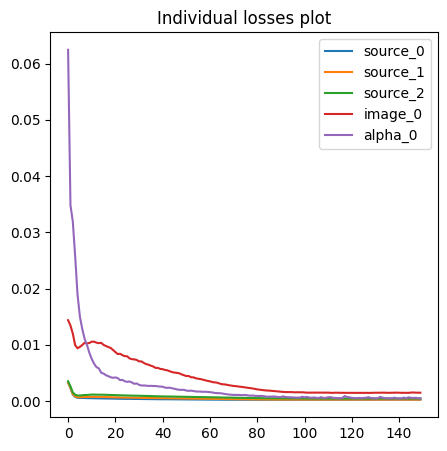

In [10]:
plot, axes = plt.subplots(1,1)
plot.set_size_inches(5,5)
for key in list(individual_losses.keys()):
    axes.plot(history_losses[key],label=key)
axes.legend()
axes.set_title('Individual losses plot')

Text(0.5, 1.0, 'Train and val losses')

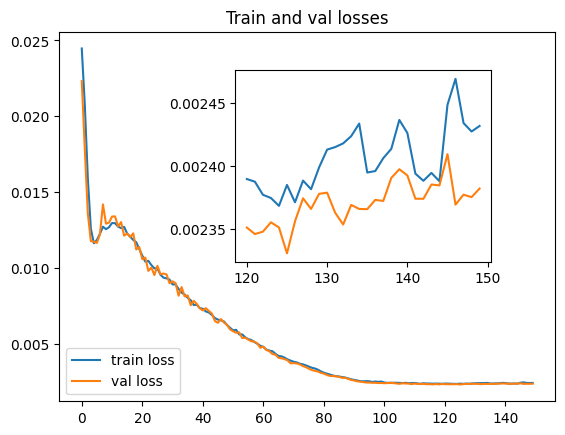

In [11]:
plot, axes = plt.subplots()
axes.plot(history['loss'],label='train loss')
axes.plot(history['val_loss'],label='val loss')
axes_2 = plot.add_axes([0.4,0.4,0.4,0.4])
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['loss'][int(0.8*len(history['loss'])):],label='train loss')
axes_2.plot(range(int(0.8*len(history['loss'])),len(history['loss'])),history['val_loss'][int(0.8*len(history['loss'])):],label='val loss')
# axes_2.set_xticks([int(0.8*EPOCHS), EPOCHS])
axes.legend(loc='lower left')
axes.set_title('Train and val losses')

### Loading the best performing model

In [12]:
# Loads the model weights at the lowest validation score

alpha_model.load_state_dict(best_weights)
print(best_val_loss)

0.0026649127123128695


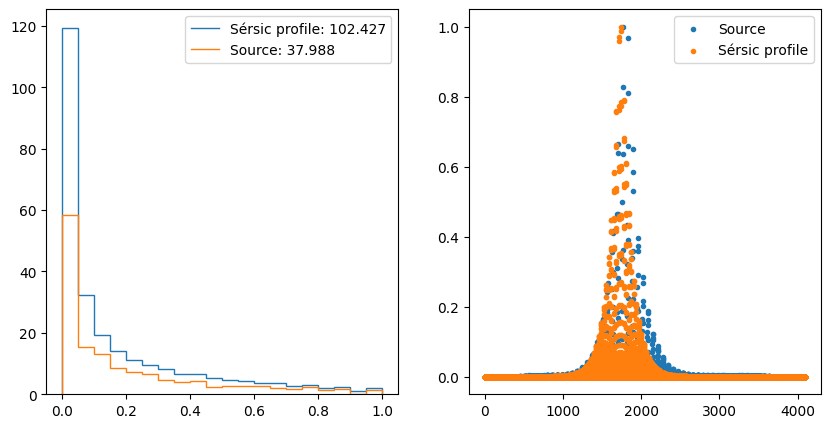

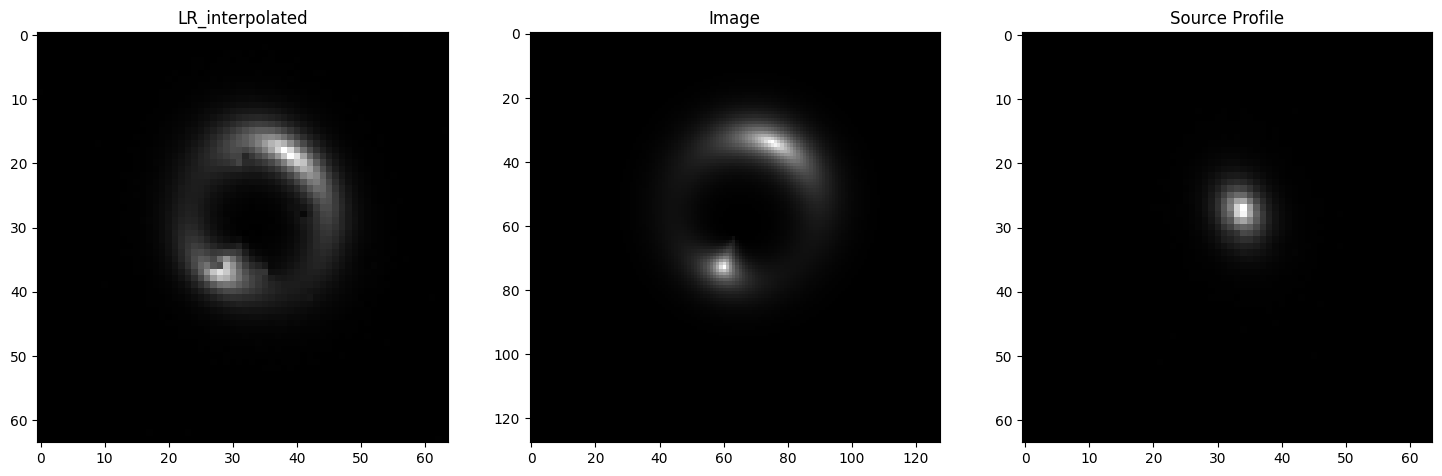

In [13]:
show_random_image(give_random_image(val_dataset, alpha_model, len(val_dataset)))

In [14]:
# Saves the training progress as GIFs of the reconstructed source and the super-resolved images

history['images'][0].save('images.gif',save_all=True, append_images = history['images'][1:], optimize=False, duration=100, loop=0)
history['lr'][0].save('lr.gif',save_all=True, append_images = history['lr'][1:], optimize=False, duration=100, loop=0)
history['source'][0].save('source.gif',save_all=True, append_images = history['source'][1:], optimize=False, duration=100, loop=0)

In [15]:
torch.save(best_weights, 'Weights_3.pt')